
# Stay on Target

## Predicting Customer Lifetime Value and future purchases by segment.

One of the most important metrics for a company is its Customer Equity.

It is possible to calculate Customer Equity (CE) because Customer Lifetime Value (CLV) can be measured with a reasonable degree of precision.

CLV is the predicted value of the customer over the lifetime of their relationship with the company. It is predictive, so should not be confused with historic customer profitability.

Not all customers are equally important to a firm. Maintaining long-term relation with all of them (especially the loss makers, or missing low spenders) is not optimal because at heart marketing is all about attracting and retaining profitable customers. Hence the objective of accurate CLV prediction is firstly to determine a comapnies customer equity and secondly as an input in customer acquisition decisions and customer acquisition/retention trade-offs.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
import datetime as dt
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *

#Let's make this notebook reproducible 
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5) 
plt.rcParams["figure.dpi"] = 140 

sns.set(style="ticks")
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})


## Import Data and inspect

Here we import the dataset and do some high level cleaning and data inspection before we start
modelling

In [3]:
elog = pd.read_csv('./dataset.csv')

In [4]:
elog.head()

,Unnamed: 0,customer_id,grand_total,created_at
0,0,176303.0,24.90,1/01/2016 0:00
1,1,162373.0,76.91,1/01/2016 0:09
2,2,85220.0,107.86,1/01/2016 0:14
3,3,173169.0,320.15,1/01/2016 0:26
4,4,151466.0,40.80,1/01/2016 0:27


In [5]:
''' 
Here I am removing the 'Unnamed: 0' column which was added during the csv loading.
'''

elog.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
'''
Fill all the NaN values in the customer_id column (doesn't really make sense to keep them), and then filter them
out of the dataset.
'''

elog.customer_id.fillna(0, inplace=True)
elog = elog[elog.customer_id != 0]

In [7]:
'''
Here I will also ensure that all the grand_total values are positive. I am able to do this after discussion with the
client to confirm that the negative and zero values are erroneous and not reflective of losses generated in sales.
'''

elog = elog[elog['grand_total'] > 0]

In [8]:
%%time

elog['created_at'] = pd.to_datetime(elog['created_at']).dt.date
elog['order_date'] = pd.to_datetime(elog['created_at'])
elog.drop(['created_at'], axis=1, inplace=True)

CPU times: user 24.6 s, sys: 12.9 ms, total: 24.6 s
Wall time: 24.3 s


In [9]:
elog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271671 entries, 0 to 279780
Data columns (total 3 columns):
customer_id    271671 non-null float64
grand_total    271671 non-null float64
order_date     271671 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.3 MB


In [10]:
elog.head()

,customer_id,grand_total,order_date
0,176303.0,24.90,2016-01-01
1,162373.0,76.91,2016-01-01
2,85220.0,107.86,2016-01-01
3,173169.0,320.15,2016-01-01
4,151466.0,40.80,2016-01-01


In [11]:
elog['order_date'].value_counts().sort_index(ascending=False).head(10)

2019-12-01    142
2019-11-01    156
2019-10-01    214
2019-09-01    243
2019-08-01    194
2019-07-01    227
2019-06-01    153
2019-05-01    134
2019-04-01    140
2019-03-01    224
Name: order_date, dtype: int64

In [12]:
''' 
As the transaction log has purchases into the future, we will also remove them, as it is not possible that these sales
have already occured.
'''

elog = elog[elog.order_date <= '2019-01-16']

## Converting to RFM and separating

In order to apply the lifetimes package on our model (and to do the customer segmentation) we will first need to transform our dataset from the one above into a RFM (recency, frequency, monetary_value) matrix. Luckily the lifetime package has an inbuilt method for doing this

In [13]:
%%time
returning_customers_summary = summary_data_from_transaction_data(elog, 
                                                                 customer_id_col = 'customer_id',
                                                                 datetime_col = 'order_date', 
                                                                 monetary_value_col='grand_total', 
                                                                 observation_period_end='2019-01-16')

CPU times: user 2.64 s, sys: 79.2 ms, total: 2.72 s
Wall time: 1.88 s


In [14]:
returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
33.0,4.0,434.0,477.0,68.020
78.0,2.0,449.0,792.0,80.300
96.0,4.0,479.0,526.0,267.145
177.0,0.0,0.0,748.0,0.000
190.0,5.0,1056.0,1075.0,104.328


In [15]:
'''
At this stage I will make a duplicate of the dataset to use for customer segmentation.
'''

segment = returning_customers_summary

Here I split the data set into a calibration and holdout set. We train the model on the calibration component, then test on the hold-out data. Note that the dates were arbitrarily chosen to allow for 6 months of test data.

In [16]:
%%time
calibration_period_ends = '2018-06-30'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(elog, 
                                                   customer_id_col = 'customer_id', 
                                                   datetime_col = 'order_date', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2019-01-16' )

CPU times: user 8.96 s, sys: 429 ms, total: 9.39 s
Wall time: 8.82 s


In [17]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
33.0,3.0,74.0,277.0,1.0,200
78.0,2.0,449.0,592.0,0.0,200
96.0,2.0,195.0,326.0,2.0,200
177.0,0.0,0.0,548.0,0.0,200
190.0,2.0,800.0,875.0,3.0,200


## Modelling with Modified BetaGeo-NBD

In the lifetimes package we can model the purchase behaviour using the Pareto-NBD, Betageo-NBD and Modified Betageo-NBD (MBG/NBD) models. By testing the different models on the dataset, I found that in this particular case the MBG/NBD model provided the greatest accuracy over the training data, so I present the results specifically for this model below.

The MBG/NBD model makes certain assumptions, namely:
 - While active, the number of transactions made by a customer follows a Poisson process with transaction rate λ.
 - Heterogeneity in λ across customers follows a Gamma distribution with shape parameter r and scale parameter α.
 - At time zero and right after each purchase the customer becomes inactive with a constant probability p.
 - Heterogeneity in p across customers follows a Gamma distribution with parameter a and b.
 - The transaction rate λ and the dropout probability p vary independently across customers.

In [18]:
%%time

'''
Here we import the MBG/NBD fitter from the lifetimes package and fit it to our calibration data. By printing the 
model fit we can observe its parameters
'''

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
           summary_cal_holdout['recency_cal'], 
           summary_cal_holdout['T_cal'],
           verbose=True)

Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: -1.042676
         Iterations: 191
         Function evaluations: 328
CPU times: user 3.22 s, sys: 13.2 ms, total: 3.23 s
Wall time: 3.23 s


In [19]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 69211 subjects, a: 0.38, alpha: 97.37, b: 0.55, r: 0.67>


## Using Gamma-Gamma model to predict lifetime value

In order to subsequently calculate the customer lifetime value for this dataset we can now apply a Gamma-Gamma model.

This model assumes that there is no relationship between the monetary value and the purchase frequency (which should be the case in a continuous non-contractual business). We need to to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [20]:
returning_customers_summary = returning_customers_summary[returning_customers_summary['frequency'] > 0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,0.01239
frequency,0.01239,1.00000


In [21]:
%%time 

'''
As the above shows a low level of correlation between the monetary-value and frequency, we can successfully apply the
Gamma-Gamma model.
'''

from lifetimes import GammaGammaFitter

gg = GammaGammaFitter(penalizer_coef = 0.01)
gg.fit(returning_customers_summary['frequency'],
       returning_customers_summary['monetary_value'],
       verbose=True)


Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: 6.783516
         Iterations: 106
         Function evaluations: 197
Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: 6.783516
         Iterations: 118
         Function evaluations: 212
Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: 6.783516
         Iterations: 111
         Function evaluations: 204
Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: 6.783516
         Iterations: 101
         Function evaluations: 181
CPU times: user 5.24 s, sys: 2.29 s, total: 7.53 s
Wall time: 5.07 s


In [22]:
print(gg)

<lifetimes.GammaGammaFitter: fitted with 32500 subjects, p: 3.96, q: 0.49, v: 3.85>


## Predicting values for each customer

We are able to now use this data to observe the specific probability of purchase and lifetime value for each specific customer over a specific time period. Here I have chosen to predict purchases and CLV over the next 3 months.

In [23]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                     summary_cal_holdout['frequency_cal'], 
                                                                     summary_cal_holdout['recency_cal'], 
                                                                     summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                      summary_cal_holdout['recency_cal'], 
                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

summary_cal_holdout['clv'] = gg.customer_lifetime_value(mbgnbd, #the model fitted
                                                        returning_customers_summary['frequency'],
                                                        returning_customers_summary['recency'],
                                                        returning_customers_summary['T'],
                                                        returning_customers_summary['monetary_value'],
                                                        time=3, # months
                                                        discount_rate=0
                                                       )

summary_cal_holdout['clv'] += (-1*summary_cal_holdout['clv'].min())

In [24]:
display(summary_cal_holdout.sample(2).T)

customer_id,190667.0,157574.0
frequency_cal,1.000000,1.000000
recency_cal,158.000000,40.000000
T_cal,775.000000,897.000000
frequency_holdout,0.000000,0.000000
duration_holdout,200.000000,200.000000
predicted_purchases,0.058694,0.019537
p_alive,0.350000,0.130000
clv,5.672769,1.138583


In [25]:
'''
And here we can view the purchasers with the highest predit CLV over the next 3 months. Further discussion with the
client would be required regarding customer_id 27758.0 as they appear to be an abnormally high purchaser.
'''

summary_cal_holdout.sort_values(by='clv', ascending=False).head(10)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases,p_alive,clv
customer_id,,,,,,,,
27758.0,57.0,883.0,888.0,7.0,200,5.135895,0.99,12094.156326
271091.0,30.0,179.0,179.0,42.0,200,9.341732,0.99,2904.723503
262737.0,6.0,468.0,535.0,8.0,200,0.826208,0.89,1707.599563
4033.0,80.0,871.0,909.0,10.0,200,6.427814,0.91,1536.185127
155445.0,60.0,864.0,873.0,20.0,200,5.473415,0.99,1333.658783
63691.0,23.0,904.0,910.0,4.0,200,2.043427,0.98,1289.605179
255303.0,9.0,232.0,303.0,1.0,200,1.660183,0.79,1152.157131
174334.0,41.0,788.0,809.0,5.0,200,3.968810,0.98,1128.557154
180052.0,44.0,805.0,864.0,6.0,200,3.596991,0.88,1052.970449


## Model assessment

Here we can view how well our modelling is fitting the data

CPU times: user 14.3 s, sys: 24.1 ms, total: 14.3 s
Wall time: 14.3 s


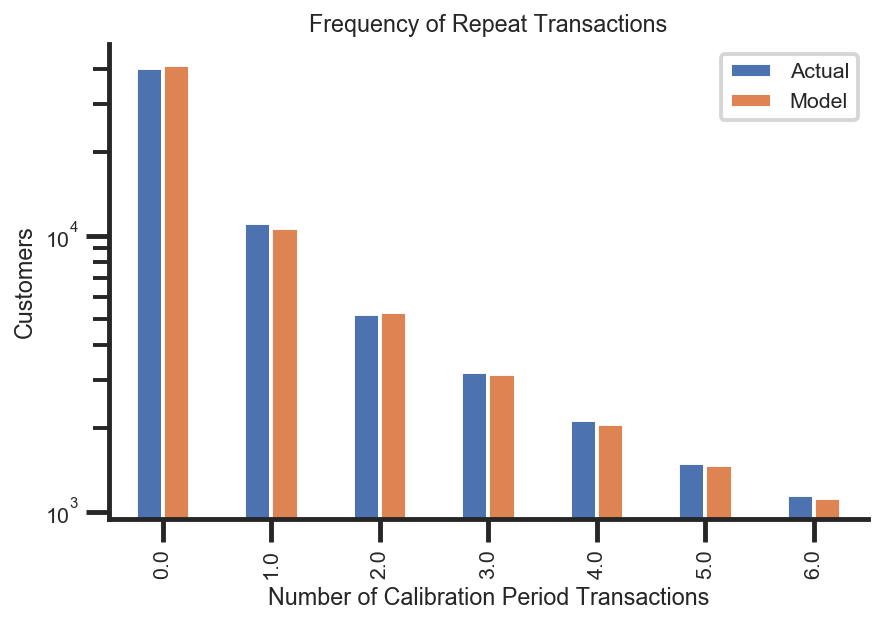

In [26]:
%%time 

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

CPU times: user 3.02 s, sys: 133 ms, total: 3.15 s
Wall time: 2.5 s


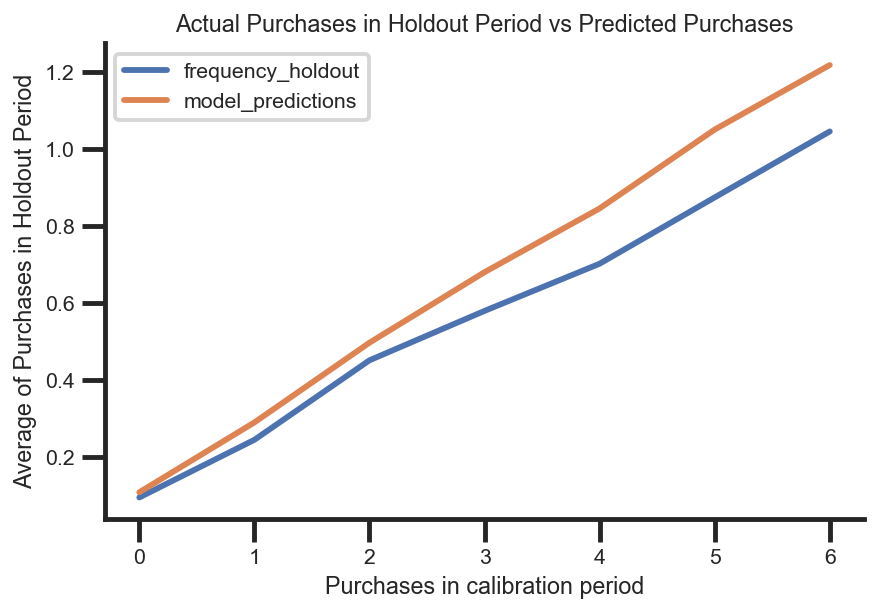

In [27]:
%%time 

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

From the above charts we can observe a good fit within the calibration data and a pretty good fit in predicted sales over the holdout-period from the earlier data. We can also visualise the probability of whether a customer is alive at a set time.

Probability that customer is alive today is 0.61


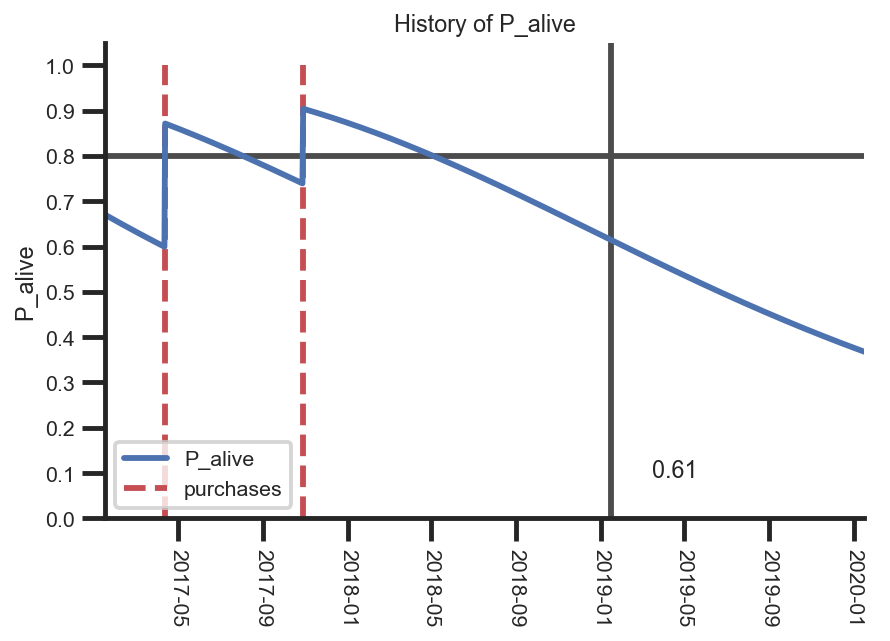

In [28]:
from lifetimes.plotting import plot_history_alive
from datetime import datetime
from datetime import date
from pylab import figure, text, scatter, show

individual = summary_cal_holdout.iloc[4940]

id = individual.name
t = 365*50

today = datetime.strptime('2019-01-16', '%Y-%m-%d').date()
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

sp_trans = elog.loc[elog['customer_id'] == id]

from lifetimes.utils import calculate_alive_path

t = (today - sp_trans.order_date.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, sp_trans, 'order_date', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

t = (one_year_from_now - sp_trans.order_date.min().date()).days
ax = plot_history_alive(mbgnbd, t, sp_trans, 'order_date', start_date=two_year_ago) #, start_date='2016-01-01'
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

ax.set_xlim(two_year_ago, one_year_from_now) # sp_trans.ORDER_DATE.min()
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()

We can also predict the number of transactions over time. Note that in order to so this, we need to rename the columns, specifically the order_date to date.

In [29]:
elog.head()

,customer_id,grand_total,order_date
0,176303.0,24.90,2016-01-01
1,162373.0,76.91,2016-01-01
2,85220.0,107.86,2016-01-01
3,173169.0,320.15,2016-01-01
4,151466.0,40.80,2016-01-01


In [30]:
elog.columns = ['customer_id', 'sale_amount', 'date']

In [31]:
%%time
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max() - elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'customer_id', t)

CPU times: user 11.7 s, sys: 237 ms, total: 11.9 s
Wall time: 11 s


CPU times: user 11.7 s, sys: 247 ms, total: 12 s
Wall time: 11 s


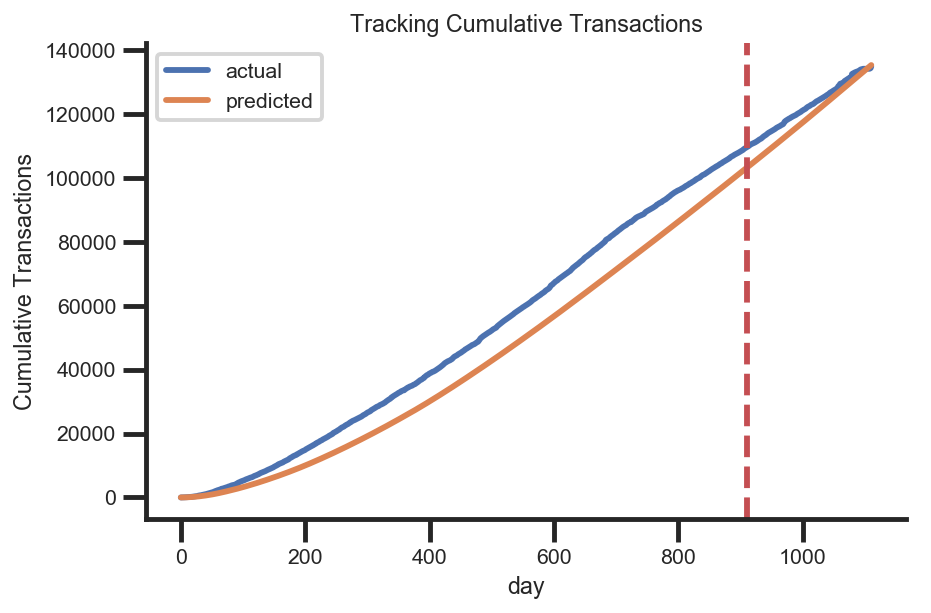

In [32]:
%%time
# Calibration period = 2016-09-04 to 2017-09-30

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max() - elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'customer_id', t, t_cal, freq='D')
sns.despine()

CPU times: user 11.9 s, sys: 242 ms, total: 12.2 s
Wall time: 11.2 s


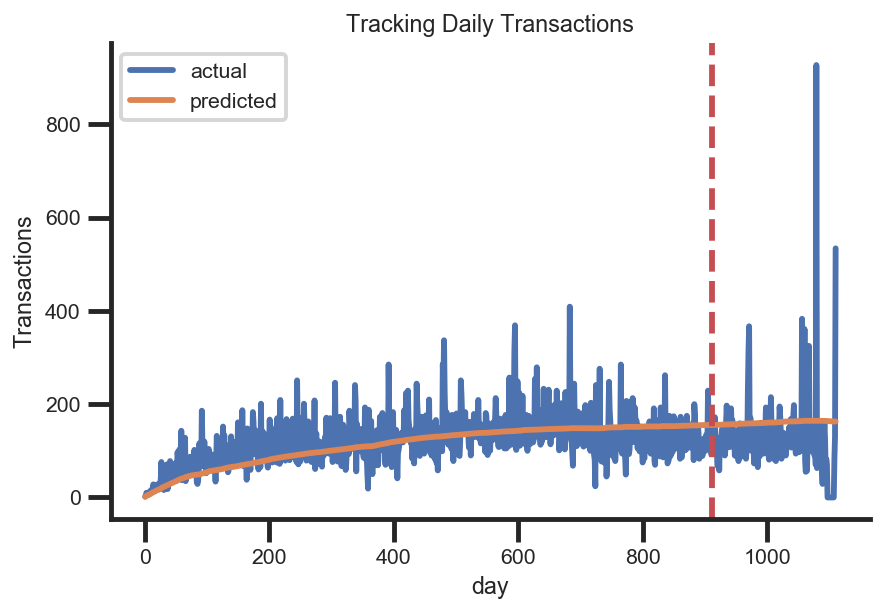

In [33]:
%%time 

from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'customer_id', t, t_cal, freq='D')
sns.despine()

So from the above graphs, we can be highly confident in the predictive power of our model. We can also use it to find the average customer lifetime value of our customers.


In [34]:
print("Expected conditional average revenue: $%s, Average revenue: $%s" % (
       np.round(gg.conditional_expected_average_profit(
           returning_customers_summary['frequency'],
           returning_customers_summary['monetary_value']).mean(), 2),
       np.round(returning_customers_summary[returning_customers_summary['frequency']>0]['monetary_value'].mean(), 2)
))  

Expected conditional average revenue: $153.64, Average revenue: $140.47


## Combining dataframes

Now I will merge together the two dataframes to get all the data in a singular one.

In [35]:
returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
33.0,4.0,434.0,477.0,68.020000
78.0,2.0,449.0,792.0,80.300000
96.0,4.0,479.0,526.0,267.145000
190.0,5.0,1056.0,1075.0,104.328000
253.0,9.0,700.0,1102.0,115.035556


In [36]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases,p_alive,clv
customer_id,,,,,,,,
33.0,3.0,74.0,277.0,1.0,200,0.295925,0.35,45.401124
78.0,2.0,449.0,592.0,0.0,200,0.267794,0.79,15.148638
96.0,2.0,195.0,326.0,2.0,200,0.392830,0.72,162.867630
177.0,0.0,0.0,548.0,0.0,200,0.026813,0.29,NaN
190.0,2.0,800.0,875.0,3.0,200,0.205844,0.85,43.131332


In [37]:
summary_cal_holdout.reset_index(inplace=True)
summary_cal_holdout.drop(['frequency_cal', 'recency_cal', 'T_cal', 'frequency_holdout', 'duration_holdout'], axis=1, inplace=True)
returning_customers_summary.reset_index(inplace=True)

In [38]:
clv = pd.merge(summary_cal_holdout, returning_customers_summary, how='left', on='customer_id')

## Customer segmentation

We are now going to take the dataframe that we duplicated earlier and use it to segment the customers based on their RFM values. 

First, lets recall what the dataset contains.

In [39]:
segment.head()

,frequency,recency,T,monetary_value
customer_id,,,,
33.0,4.0,434.0,477.0,68.020
78.0,2.0,449.0,792.0,80.300
96.0,4.0,479.0,526.0,267.145
177.0,0.0,0.0,748.0,0.000
190.0,5.0,1056.0,1075.0,104.328


In [40]:
segment = segment[segment['frequency'] != 0]

In [41]:
'''
First we will convert the rfm from continous values to quartile values.
'''

quantiles = segment.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'recency': {0.25: 142.0, 0.5: 340.0, 0.75: 632.0},
 'T': {0.25: 613.0, 0.5: 840.0, 0.75: 1023.0},
 'monetary_value': {0.25: 74.86327777777778,
  0.5: 115.46199999999999,
  0.75: 168.49249999999998}}

In [42]:
'''
Set the re-naming protocol for the different quantiles.
'''

def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [43]:
segment['r_score'] = segment['recency'].apply(RScore, args=('recency',quantiles,))
segment['f_score'] = segment['frequency'].apply(FMScore, args=('frequency',quantiles,))
segment['m_score'] = segment['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segment.reset_index(inplace=True)
segment.head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score
0,33.0,4.0,434.0,477.0,68.020000,3,2,4
1,78.0,2.0,449.0,792.0,80.300000,3,3,3
2,96.0,4.0,479.0,526.0,267.145000,3,2,1
3,190.0,5.0,1056.0,1075.0,104.328000,4,2,3
4,253.0,9.0,700.0,1102.0,115.035556,4,1,3


In [44]:
'''
Now we separate out the quartile columns into a new table to perform the segmentation.
'''

rfmTableScores = segment[['customer_id','r_score', 'f_score', 'm_score']].copy()

In [45]:
rfmTableScores.set_index('customer_id', inplace=True)

I decided to segment the customer base using K-Means clustering, as I would expect neighbouring obervations to exhibit similar purchasing behaviours. But first I need to determine the optimal number of clusters.

In [46]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfmTableScores)
    wcss.append(kmeans.inertia_)

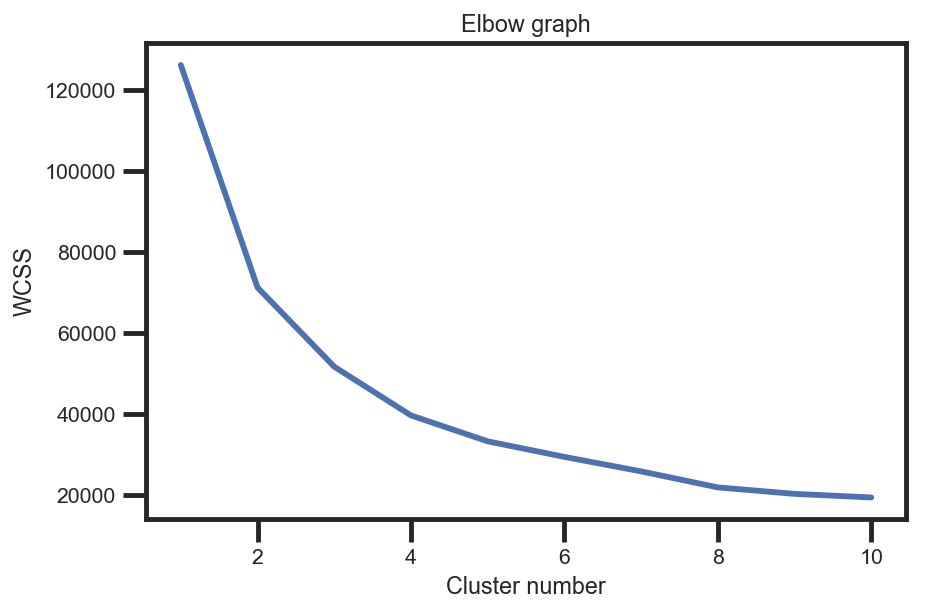

In [47]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

From the above elbow graph, we can see a very clear distinction between at 2 groups, and pretty marginal difference after that, flattening out again beyond 5 clusters. Accordingly, I decided to cluster the datapoint around 5 centroids to try and provide optimal segmentation.

In [48]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfmTableScores)

In [49]:
segment['clusters'] = clusters
segment.head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
0,33.0,4.0,434.0,477.0,68.020000,3,2,4,0
1,78.0,2.0,449.0,792.0,80.300000,3,3,3,4
2,96.0,4.0,479.0,526.0,267.145000,3,2,1,2
3,190.0,5.0,1056.0,1075.0,104.328000,4,2,3,0
4,253.0,9.0,700.0,1102.0,115.035556,4,1,3,0


In [50]:
segment.clusters.value_counts()

3    8116
2    7833
0    6781
1    6013
4    3757
Name: clusters, dtype: int64

In [51]:
segment.r_score.value_counts()

2    8137
3    8132
1    8127
4    8104
Name: r_score, dtype: int64

In [52]:
'''
By analysing each cluster we can assess which customer type it is predominantly made of, and then assign it a more
descriptive tag. I do this for all clusters before providing descriptors.


We can observe that this cluster is the segment representing small, non repeat purchasers that have purchased recently,
I call these missing loyal spenders.
'''

segment[segment.clusters == 0].head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
0,33.0,4.0,434.0,477.0,68.020000,3,2,4,0
3,190.0,5.0,1056.0,1075.0,104.328000,4,2,3,0
4,253.0,9.0,700.0,1102.0,115.035556,4,1,3,0
10,655.0,6.0,570.0,1019.0,102.511667,3,1,3,0
12,742.0,3.0,161.0,1065.0,87.020000,2,2,3,0


In [53]:
'''
The big spenders.
'''

segment[segment.clusters == 1].head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
19,1073.0,1.0,30.0,67.0,463.92,1,4,1,1
31,2223.0,2.0,227.0,1092.0,126.74,2,3,2,1
40,2704.0,1.0,296.0,906.0,143.88,2,4,2,1
42,2737.0,1.0,101.0,329.0,146.92,1,4,2,1
43,2743.0,1.0,66.0,952.0,202.40,1,4,1,1


In [54]:
'''
The missing loyal big spenders.
'''

segment[segment.clusters == 2].head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
2,96.0,4.0,479.0,526.0,267.145000,3,2,1,2
6,325.0,9.0,757.0,1099.0,153.416667,4,1,2,2
7,525.0,3.0,1027.0,1070.0,125.000000,4,2,2,2
8,527.0,6.0,964.0,985.0,290.443333,4,1,1,2
9,580.0,3.0,208.0,744.0,157.630000,2,2,2,2


In [55]:
'''
The small spenders.
'''

segment[segment.clusters == 3].head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
17,967.0,2.0,248.0,354.0,14.925,2,3,4,3
27,1937.0,2.0,166.0,943.0,103.900,2,3,3,3
32,2280.0,1.0,28.0,859.0,78.910,1,4,3,3
51,3056.0,2.0,91.0,109.0,9.980,1,3,4,3
53,3257.0,1.0,165.0,790.0,113.950,2,4,3,3


In [56]:
'''
The missing spenders.
'''

segment[segment.clusters == 4].head()

,customer_id,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters
1,78.0,2.0,449.0,792.0,80.300,3,3,3,4
5,273.0,1.0,547.0,906.0,107.750,3,4,3,4
13,912.0,2.0,824.0,1077.0,245.945,4,3,1,4
14,919.0,1.0,381.0,548.0,180.950,3,4,1,4
23,1613.0,2.0,462.0,805.0,120.975,3,3,2,4


In [57]:
'''
I then amend the dataframe with these new descriptors.
'''

m1 = segment.clusters == 0
m2 = segment.clusters == 1
m3 = segment.clusters == 2
m4 = segment.clusters == 3
m5 = segment.clusters == 4

segment['group'] = np.select([m1, m2, m3, m4, m5], ['missing loyal spenders', 'big spenders',
                                                    'missing loyal big spenders', 'small spenders', 
                                                    'missing spenders'], default=0)

In [58]:
''' 
We can then suggest some personalised strategies for each of these market segments.
'''

m1 = segment.clusters == 0
m2 = segment.clusters == 1
m3 = segment.clusters == 2
m4 = segment.clusters == 3
m5 = segment.clusters == 4

segment['strategy'] = np.select([m1, m2, m3, m4, m5], ['Push upsell, target complementary purchases', 
                                                       'Target with new products, loyalty programs',
                                                       'Target with price incentives, complementary purchases',
                                                       'Push upsell, loyalty program',
                                                       'Push upsell, target with price incentives'], default=0)


## Combine dataframes

We will now combine the segmentation dataframe with the predictive modelling one to return a complete dataset that can be exported into Tableau to dashboarding.

In [59]:
segment.drop(['frequency', 'recency', 'T', 'monetary_value'], axis=1, inplace=True)

In [60]:
segment.head()

,customer_id,r_score,f_score,m_score,clusters,group,strategy
0,33.0,3,2,4,0,missing loyal spenders,"Push upsell, target complementary purchases"
1,78.0,3,3,3,4,missing spenders,"Push upsell, target with price incentives"
2,96.0,3,2,1,2,missing loyal big spenders,"Target with price incentives, complementary pu..."
3,190.0,4,2,3,0,missing loyal spenders,"Push upsell, target complementary purchases"
4,253.0,4,1,3,0,missing loyal spenders,"Push upsell, target complementary purchases"


In [61]:
clv.head()

,customer_id,predicted_purchases,p_alive,clv,frequency,recency,T,monetary_value
0,33.0,0.295925,0.35,45.401124,4.0,434.0,477.0,68.020
1,78.0,0.267794,0.79,15.148638,2.0,449.0,792.0,80.300
2,96.0,0.392830,0.72,162.867630,4.0,479.0,526.0,267.145
3,177.0,0.026813,0.29,NaN,NaN,NaN,NaN,NaN
4,190.0,0.205844,0.85,43.131332,5.0,1056.0,1075.0,104.328


In [62]:
final = pd.merge(clv, segment, how='left', on='customer_id')

In [73]:
final.to_csv('./final2.csv')

Now using this data I am able to calculate the Customer Equity of the company for the next three months by taking the sum of the clv values of he customer base as a whole multiplied by an arbitrary profit margin of 5% after costs.

In [64]:
customer_equity = (final.clv.sum() * 0.05)

In [65]:
print(customer_equity)

74170.28961986522


We can also demonstrate the benefit of targetting our high value users over the low value ones by taking the difference in expected sales from between the different catagories. For example if we look at the clv values for the loyal spenders (6387) and compare it with the clv values of missing loyal big spenders (6485) we can observe the difference in revenue that each can potentially bring in with a more targeted campaign.

In [66]:
final.head()

,customer_id,predicted_purchases,p_alive,clv,frequency,recency,T,monetary_value,r_score,f_score,m_score,clusters,group,strategy
0,33.0,0.295925,0.35,45.401124,4.0,434.0,477.0,68.020,3.0,2.0,4.0,0.0,missing loyal spenders,"Push upsell, target complementary purchases"
1,78.0,0.267794,0.79,15.148638,2.0,449.0,792.0,80.300,3.0,3.0,3.0,4.0,missing spenders,"Push upsell, target with price incentives"
2,96.0,0.392830,0.72,162.867630,4.0,479.0,526.0,267.145,3.0,2.0,1.0,2.0,missing loyal big spenders,"Target with price incentives, complementary pu..."
3,177.0,0.026813,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,190.0,0.205844,0.85,43.131332,5.0,1056.0,1075.0,104.328,4.0,2.0,3.0,0.0,missing loyal spenders,"Push upsell, target complementary purchases"


In [67]:
bigs = final[final['group'] == 'missing loyal big spenders']

In [68]:
bigs.clv.sum()

891447.2723391624

In [71]:
loyals = final[final['group'] == 'missing loyal spenders']

In [72]:
loyals.clv.sum()

303501.27506441437

So we can see that the big spenders will bring in approximately 3 times more revenue over this period, or more than $105,000 dollars in additional sales.